# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
#!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/ > /dev/null # no output
#!python -m pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/ > /dev/null --user 
!python -m pip install /home/dohee/Documents/kaggle/Bengali/pretrained-models.pytorch/ > /dev/null --user 


In [2]:
!pip install tqdm

In [3]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/bengaliaicv19feather/train_image_data_1.feather
../input/bengaliaicv19feather/train_image_data_3.feather
../input/bengaliaicv19feather/test_image_data_3.feather
../input/bengaliaicv19feather/test_image_data_2.feather
../input/bengaliaicv19feather/train_image_data_0.feather
../input/bengaliaicv19feather/test_image_data_1.feather
../input/bengaliaicv19feather/test_image_data_0.feather
../input/bengaliaicv19feather/train_image_data_2.feather
../input/bengaliai-cv19/class_map.csv
../input/bengaliai-cv19/train_image_data_1.parquet
../input/bengaliai-cv19/train_image_data_0.parquet
../input/bengaliai-cv19/test_image_data_1.parquet
../input/bengaliai-cv19/train_image_data_3.parquet
../input/bengaliai-cv19/test.csv
../input/bengaliai-cv19/test_image_data_2.parquet
../input/bengaliai-cv19/train.csv
../input/bengaliai-cv19/train_image_data_2.parquet
../input/bengaliai-cv19/test_image_data_3.parquet
../input/bengaliai-cv19/test_image_data_0.parquet
../input/bengaliai-cv19/sample_submissi

In [5]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [6]:
debug=False
submission=False
batch_size=32*6
device='cuda:0'
out='.'
image_size=64*2
arch='pretrained'
model_name='se_resnext50_32x4d'

In [7]:
datadir = Path('../input/bengaliai-cv19')
featherdir = Path('../input/bengaliaicv19feather')
outdir = Path('./save')

In [8]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [9]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [10]:
os.listdir(r"../input")

['bengaliaicv19feather', 'bengaliai-cv19']

In [11]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)


image_df_list 4
CPU times: user 10.5 s, sys: 21.6 s, total: 32.1 s
Wall time: 1min 55s


In [12]:
# Grapheme_root data generation

In [13]:
import copy
train_new = copy.copy(train)

toadd_dict = dict(1000-train['grapheme_root'].value_counts().iloc[62:])

for label in toadd_dict:
    subdf = train[train['grapheme_root']==label]
    subdf = pd.concat([subdf for i in range(toadd_dict[label]//subdf.shape[0]+1)],axis=0)
    train_new = pd.concat([train_new, subdf.iloc[:toadd_dict[label],:]],axis=0)
    
    # new train_images
    subarr = train_images[subdf.iloc[:toadd_dict[label],:].index,:,:]
    train_images = np.concatenate([train_images,subarr],axis=0)
    
train = copy.copy(train_new)
del train_new

In [14]:
train['grapheme_root'].value_counts()

72     5736
64     5596
13     5420
107    5321
23     5149
       ... 
62     1000
63     1000
66     1000
67     1000
0      1000
Name: grapheme_root, Length: 168, dtype: int64

In [1]:
train_images.shape

NameError: name 'train_images' is not defined

<a id="dataset"></a>
# Dataset

In [13]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [14]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        x = x.astype(np.double)
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
train_dataset = BengaliAIDataset(train_images, train_labels)

image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


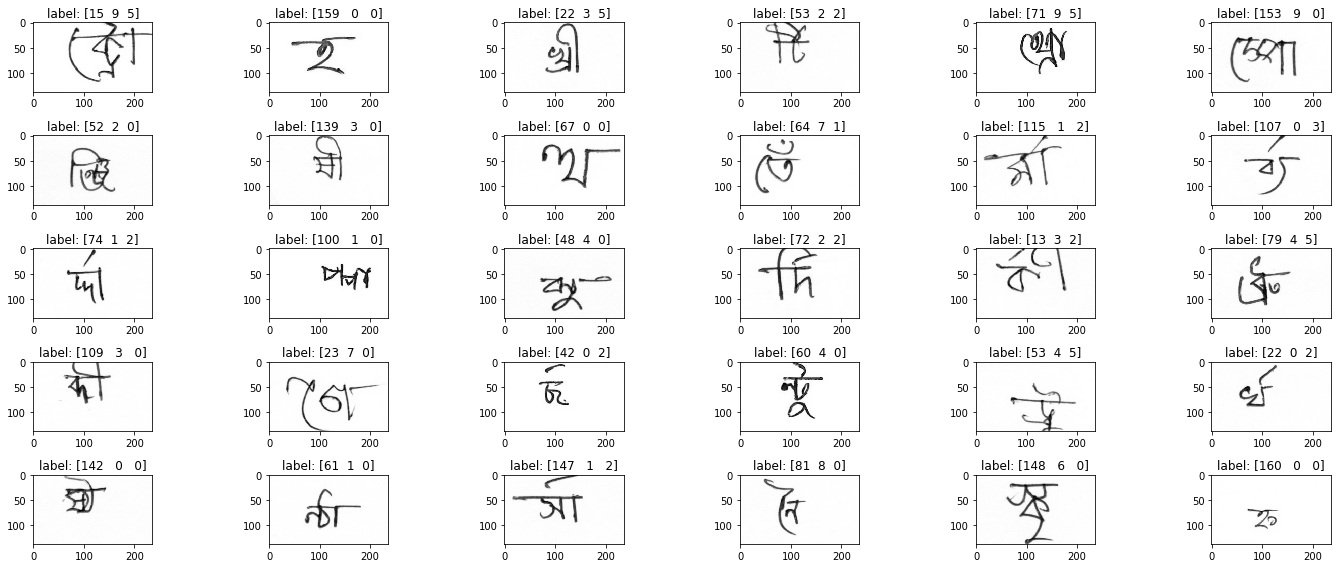

<Figure size 432x288 with 0 Axes>

In [16]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [17]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    
    #print("img.shape:", img.shape)
    
    # horizontal flip
    #if np.random.rand()<0.5:
    #img = img[:,::-1]
    
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 4
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    #tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
    #                        translation=(tx, ty))
    tform = AffineTransform(scale=(sx, sy), shear=shear_angle, rotation=rot_angle)
    
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    
    image[image < 20./255.] = 0
    
    is_black = image > threshold
    is_black[:5,:] = 0
    is_black[-5:,:] = 0
    is_black[:,:5] = 0
    is_black[:,-5:] = 0
    #is_black = connected_comp(is_black)
    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left-5:height - right+5, top-5:width - bottom+5]
    
    lx, ly = height - right - left + 10, width - bottom - top + 10
    l = max(lx,ly)
    #make sure that the aspect ratio is kept in rescaling
    cropped_image = np.pad(cropped_image, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    
    # scaling
    cropped_image = cropped_image*(1/cropped_image.max())
    
    #pad
    cropped_image = np.pad(cropped_image, 8, pad_with)
    
    return cropped_image

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

In [18]:
# Erosion
def erosion(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.erode(img, kernel, iterations=1)
    return img

# Dilation
def dilation(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.dilate(img, kernel, iterations=1)
    return img


def get_random_kernel():
    structure = np.random.choice([cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS])
    kernel = cv2.getStructuringElement(structure, tuple(np.random.randint(1, 3, 2)))
    return kernel

# Opening
def opening(img):
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    return img

#Closing
def closing(img):
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    return img


## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

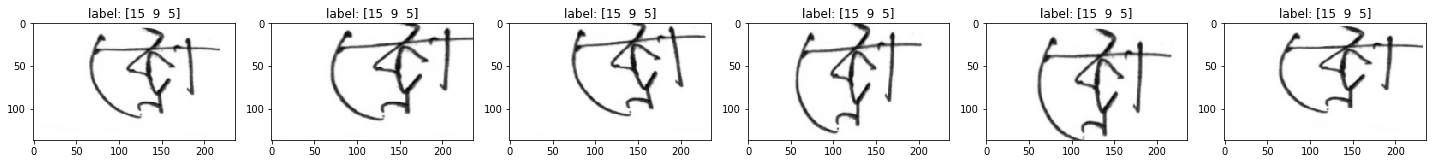

In [19]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

## crop image

Here I crop image

## resize image

We need to resize image after crop, to align image size for CNN batch training.

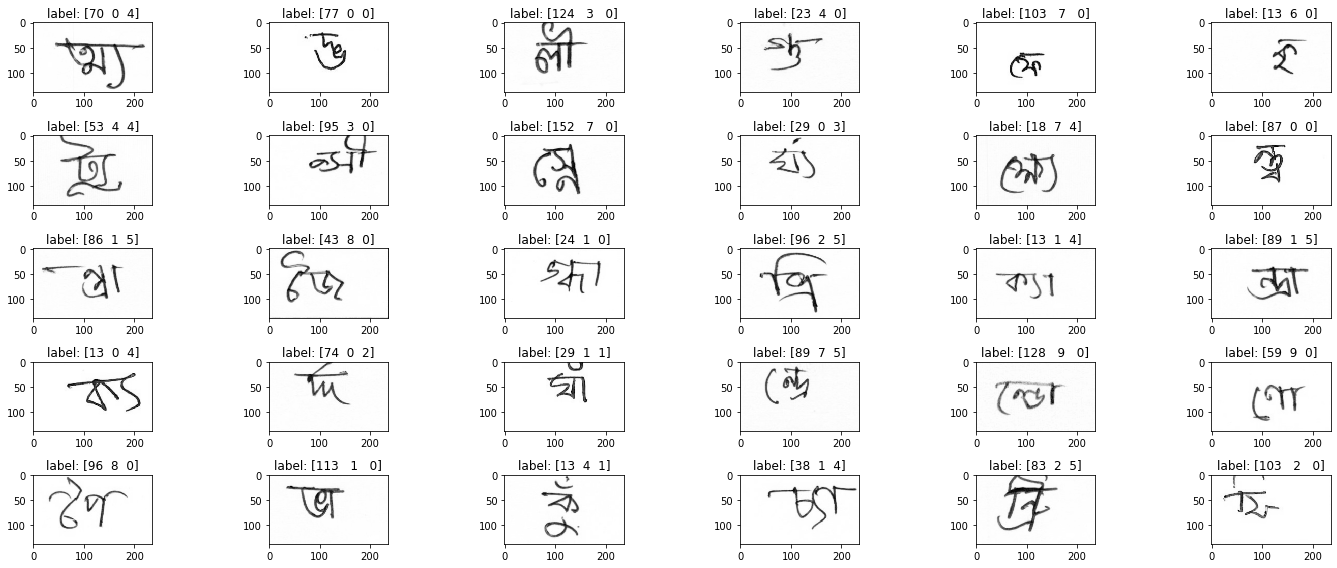

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

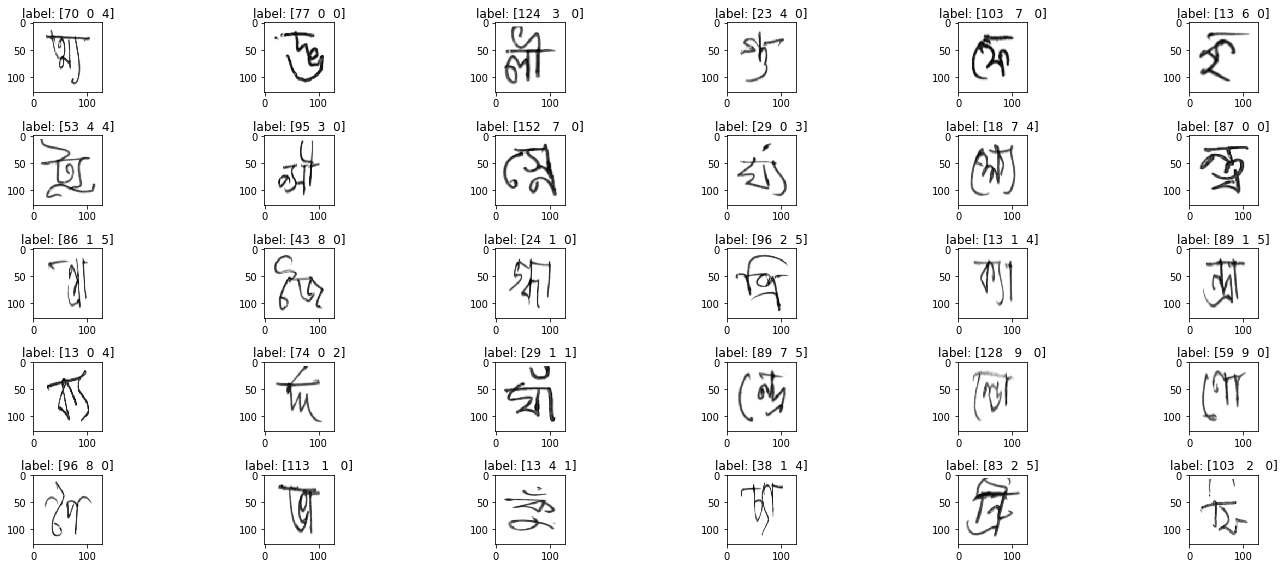

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(resize(crop_char_image(image, threshold=40./255.)), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [22]:
# class Transform:
#     def __init__(self, affine=True, crop=True, size=(64, 64),
#                  normalize=True, train=True, threshold=40.,
#                  sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
#                  grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
#                  piece_affine_ratio=0., ssr_ratio=0.):
#         self.affine = affine
#         self.crop = crop
#         self.size = size
#         self.normalize = normalize
#         self.train = train
#         self.threshold = threshold / 255.
#         self.sigma = sigma / 255.

#         self.blur_ratio = blur_ratio
#         self.noise_ratio = noise_ratio
#         self.cutout_ratio = cutout_ratio
#         self.grid_distortion_ratio = grid_distortion_ratio
#         self.elastic_distortion_ratio = elastic_distortion_ratio
#         self.random_brightness_ratio = random_brightness_ratio
#         self.piece_affine_ratio = piece_affine_ratio
#         self.ssr_ratio = ssr_ratio

#     def __call__(self, example):
        
        
#         if self.train:
#             x, y = example
#         else:
#             x = example
            
#         # --- Augmentation ---
#         if self.affine:
#             x = affine_image(x)

            
#         # --- Train/Test common preprocessing ---
#         if self.crop:
#             x = crop_char_image(x, threshold=self.threshold)
#         if self.size is not None:
#             x = resize(x, size=self.size)
#         #if self.sigma > 0.:
#         #    x = add_gaussian_noise(x, sigma=self.sigma)

        
#         #plt.imshow(x)
#         #plt.show()
        
#         # albumentations...
#         x = x.astype(np.float32)
#         assert x.ndim == 2
        
#         # 1. blur
#         if _evaluate_ratio(self.blur_ratio):
#             r = np.random.uniform()
#             if r < 0.25:
#                 x = apply_aug(A.Blur(p=1.0), x)
#             elif r < 0.5:
#                 x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
#             elif r < 0.75:
#                 x = apply_aug(A.GaussianBlur(p=1.0), x)
#             else:
#                 x = apply_aug(A.MotionBlur(p=1.0), x)
                

#         if _evaluate_ratio(self.noise_ratio):
#             r = np.random.uniform()
#             if r < 0.50:
#                 x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
#             else:
#                 x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

#         if _evaluate_ratio(self.cutout_ratio):
#             # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
#             x = apply_aug(A.Cutout(max_h_size=8, max_w_size=8, p=1.0), x)
#             #x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

#         if _evaluate_ratio(self.grid_distortion_ratio):
#             x = apply_aug(A.GridDistortion(p=1.0), x)

#         if _evaluate_ratio(self.elastic_distortion_ratio):
#             x = apply_aug(A.ElasticTransform(
#                 sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

#         if _evaluate_ratio(self.random_brightness_ratio):
#             # A.RandomBrightness(p=1.0)  # Deprecated...
#             # A.RandomContrast(p=1.0)    # Deprecated...
#             x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

#         if _evaluate_ratio(self.piece_affine_ratio):
#             x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

#         if _evaluate_ratio(self.ssr_ratio):
#             x = apply_aug(A.ShiftScaleRotate(
#                 shift_limit=0.0625,
#                 scale_limit=0.1,
#                 rotate_limit=30,
#                 p=1.0), x)
        
# #         # 난수생성
# #         const = np.random.rand(1)[0]
        
#         # Erosion, dilation
# #         if const<0.5:
# #             x = erosion(x)
# #         else:
# #             x = dilation(x)
        
        
        
# #         if const<0.15:
# #             x = erosion(x)
# #         elif const<0.3:
# #             x = dilation(x)
# #         elif const<0.45:
# #             x = opening(x)
# #         elif const<0.6:
# #             x = closing(x)
        
# #         plt.imshow(x)
# #         plt.show()

        
#         #if self.normalize:
#         #    x = (x.astype(np.double) - 0.0692) / 0.2051
#         if x.ndim == 2:
#             x = x[None, :, :]
#         x = x.astype(np.double)
#         if self.train:
#             y = y.astype(np.int64)
#             return x, y
#         else:
#             return x
        
#         # normalize by its max val
#         x = x * (255./x.max())

In [23]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']
        
        
class Transform:
    def __init__(self, affine=True, crop=False, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
                    
        # remove noise
        # x [x<28./255.] = 0
        
        # horizontal flip
        #x = x[:,:,::-1,:]

        
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
        
        

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

            
        #plt.imshow(x[0,0].cpu().numpy())
        #plt.show()
        
        #if self.normalize:
        #    x = (x.astype(np.float32) - 0.0692) / 0.2051
        # normalize by its max val
        # x = x * (255./x.max())
        
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x
        

In [24]:
# train_transform = Transform(
#     size=(image_size, image_size), threshold=20.,
#     sigma=-1., blur_ratio=0.1, noise_ratio=0, cutout_ratio=0.2,
#     grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
#     piece_affine_ratio=0.2, ssr_ratio=0.2)
# train_dataset = BengaliAIDataset(train_images, train_labels,
#                                  transform=train_transform)

# for i in range(10):
#     train_dataset[0]

In [25]:
train_transform = Transform(
    size=(128, 128), threshold=40.,
    sigma=-1., blur_ratio=0.2, noise_ratio=0.2, cutout_ratio=0.2,
    grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
    piece_affine_ratio=0.2, ssr_ratio=0.2)
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

### Let's final check the processed images, which will be trained by the model.

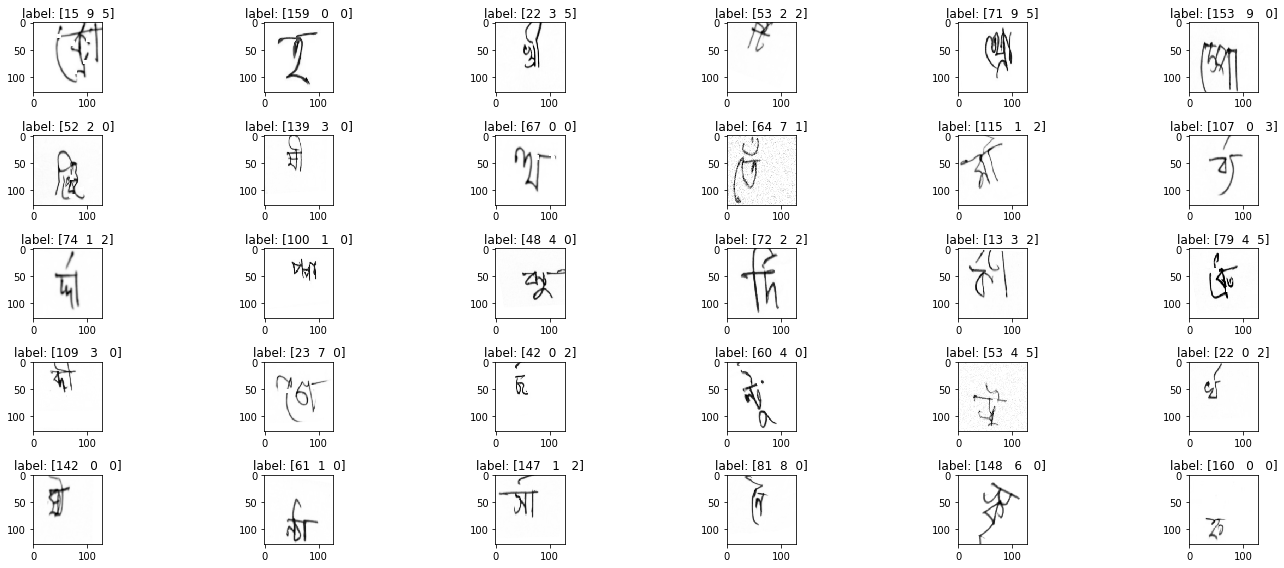

In [26]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [27]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [28]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [29]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [30]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

## Classifier

In [32]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    while lam > 0.999:
        lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
#     print(lam)
#     print(data.shape)
#     print(indices)
#     print(bbx1, bbx2, bby1, bby2)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [33]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.double)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor.float()
        
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
        
    def forward(self, x, y=None):
        
        const = np.random.randint(6)
        if const<2:        
            # mixup
            data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data
        elif const<4:        
            # cutmix
            data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data
            
        #plt.imshow(x[0,0].cpu().numpy())
        #plt.show()
        
        pred = self.predictor(x)
        
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_grapheme #self.n_total_class
            preds = pred #torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
            
        if const<4:
            # cutmix or mixup
            targets1, targets2, targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
            preds1, preds2, preds3 = preds[0], preds[1], preds[2]
            lam = float(lam)
            loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
            loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
            loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            #loss = loss_grapheme + loss_vowel + loss_consonant
        else:
            loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
            loss_vowel = F.cross_entropy(preds[1], y[:, 1])
            loss_consonant = F.cross_entropy(preds[2], y[:, 2])
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            #loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    
    
    
    def forward_val(self, x, y=None):
        
        
        pred = self.predictor(x)
        #pred1 = self.predictor(x[:,:,::-1,:])
        #pred2 = self.predictor(x)
        #pred = (pred1+pred2)/2 
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = 2*loss_grapheme + loss_vowel + loss_consonant
        #loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

<a id="train"></a>
# Training code

## prepare data

In [34]:
# iterative-stratification

import copy
import numpy as np
import pandas as pd
import iterstrat
#!pip install iterative-stratification

#get data
nfold = 5
seed = 12

train_df = copy.copy(train)
train_df['id'] = train_df['image_id'].apply(lambda x: int(x.split('_')[1]))

X, y = train_df[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']]\
.values[:,0], train_df.values[:,1:]

train_df['fold'] = np.nan

#split data
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=nfold, random_state=seed)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    train_df.iloc[test_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

#------------------------------

n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.8)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#perm = np.random.RandomState(777).permutation(n_dataset)
#print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=train_transform,
    indices = np.array(list(train_df[train_df['fold']!=0].index)))
    #    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=False, size=(128, 128)),
    indices = np.array(list(train_df[train_df['fold']==0].index)))
#    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained='imagenet')
print('predictor', type(predictor))

/home/dohee/anaconda3/envs/Bengali/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



train_dataset 160672 valid_dataset 40168
n_total 186
predictor <class '__main__.PretrainedCNN'>


In [35]:
pretrainedmodels

<module 'pretrainedmodels' from '/home/dohee/.local/lib/python3.6/site-packages/pretrainedmodels/__init__.py'>

In [37]:
# #load weights
predictor.load_state_dict(torch.load(r"/home/dohee/Documents/kaggle/Bengali/Bengali/save/model_000030.pt"))
predictor.train()

classifier = BengaliClassifier(predictor).to(device)

In [38]:
predictor

PretrainedCNN(
  (conv0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (base_model): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(25

## Ignite utility

pytorch-ignite utility class for training

In [39]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        
#         # mixup
#         data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
#         #print(data.shape)
#         print(len(targets))
#         print(targets[0].shape)
#         print(y.shape)
        
#         print(targets)
#         print(y)

        
        loss, metrics, pred_y = classifier(x, y)
        
#         print(pred_y.shape)
#         print(pred_y)
#         print("---------------")
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        
        ####
        print(elem)
        
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'./save/model_{count:06}.pt',
                 interval=10, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            print("saving model epoch:", self.count)
            
            #self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [40]:
# def create_trainer(classifier, optimizer, device):
#     classifier.to(device)    
#     def update_fn(engine, batch):
#         classifier.train()
#         optimizer.zero_grad()

#         # batch = [elem.to(device) for elem in batch]
#         x, y = [elem.to(device) for elem in batch]        
#         x = x.float()
        
#         print(x.shape)
#         print(y.shape)
        
#         loss, metrics, pred_y = classifier(x, y)

In [41]:
# from ignite.handlers import ModelCheckpoint

# checkpoint_every = 10

# dirname = r"./save"
# engine_checkpoint = ModelCheckpoint(
#     dirname=dirname,
#     'my_model',
#     save_interval=checkpoint_every,
#     create_dir = True)

In [42]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


#optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# AdamW
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    #print(pred_y[0].shape)
    #print(pred_y[1].shape)
    pred_y = torch.cat((pred_y[0], pred_y[1], pred_y[2]), 1)
    
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))
    #ModelSnapshotHandler(predictor, filepath=outdir / 'predictor.pt'))
#trainer.add_event_handler(Events.EPOCH_COMPLETED, engine_checkpoint, {'mymodel':classifier})

In [ ]:
trainer.run(train_loader, max_epochs=70)

/home/dohee/anaconda3/envs/Bengali/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



{'epoch': 1, 'iteration': 837, 'train/loss': 2.7599021142956177, 'train/loss_grapheme': 0.9834646828463712, 'train/loss_vowel': 0.4789963585114287, 'train/loss_consonant': 0.3139763884268603, 'train/acc_grapheme': 0.6342617483074467, 'train/acc_vowel': 0.7207101254480284, 'train/acc_consonant': 0.8155080147351665, 'train/recall': 0.6858248470183104, 'valid/loss': 0.5287646476711546, 'valid/loss_grapheme': 0.17957417915264764, 'valid/loss_vowel': 0.09424992828142076, 'valid/loss_consonant': 0.07536636151018597, 'valid/acc_grapheme': 0.9586607142857145, 'valid/acc_vowel': 0.9882539682539676, 'valid/acc_consonant': 0.9877529761904759, 'valid/recall': 0.9721626751449862, 'lr': 0.003, 'elapsed_time': 1149.6976200889999}
epoch      1 train/loss  2.759902 train/loss_grapheme  0.983465 train/loss_vowel  0.478996 train/loss_consonant  0.313976 train/acc_grapheme  0.634262 train/acc_vowel  0.720710 train/acc_consonant  0.815508 train/recall  0.685825 valid/loss  0.528765 valid/loss_grapheme  0.1

{'epoch': 2, 'iteration': 1674, 'train/loss': 2.8685071967729106, 'train/loss_grapheme': 1.0213616986001264, 'train/loss_vowel': 0.4992801819025598, 'train/loss_consonant': 0.32650361511313325, 'train/acc_grapheme': 0.6512893269613705, 'train/acc_vowel': 0.7367719534050184, 'train/acc_consonant': 0.8255998606133, 'train/recall': 0.704168201198559, 'valid/loss': 0.4851295912549609, 'valid/loss_grapheme': 0.16876914937581336, 'valid/loss_vowel': 0.07815828834261213, 'valid/loss_consonant': 0.06943300318505083, 'valid/acc_grapheme': 0.9586805555555558, 'valid/acc_vowel': 0.9880059523809522, 'valid/acc_consonant': 0.9865376984126982, 'valid/recall': 0.9722509332100424, 'lr': 0.003, 'elapsed_time': 2295.312691191}
epoch      2 train/loss  2.868507 train/loss_grapheme  1.021362 train/loss_vowel  0.499280 train/loss_consonant  0.326504 train/acc_grapheme  0.651289 train/acc_vowel  0.736772 train/acc_consonant  0.825600 train/recall  0.704168 valid/loss  0.485130 valid/loss_grapheme  0.168769 

{'epoch': 3, 'iteration': 2511, 'train/loss': 3.1480820659490183, 'train/loss_grapheme': 1.1229963070593925, 'train/loss_vowel': 0.5471088387875449, 'train/loss_consonant': 0.35498060924284774, 'train/acc_grapheme': 0.6011250497809635, 'train/acc_vowel': 0.6982340203106319, 'train/acc_consonant': 0.7996515332536845, 'train/recall': 0.6590288854567685, 'valid/loss': 0.6545746742259888, 'valid/loss_grapheme': 0.21816670632078533, 'valid/loss_vowel': 0.11888629847339222, 'valid/loss_consonant': 0.09935496133707819, 'valid/acc_grapheme': 0.9539484126984128, 'valid/acc_vowel': 0.9876587301587296, 'valid/acc_consonant': 0.9864880952380951, 'valid/recall': 0.969250332996666, 'lr': 0.003, 'elapsed_time': 3429.264888533}
epoch      3 train/loss  3.148082 train/loss_grapheme  1.122996 train/loss_vowel  0.547109 train/loss_consonant  0.354981 train/acc_grapheme  0.601125 train/acc_vowel  0.698234 train/acc_consonant  0.799652 train/recall  0.659029 valid/loss  0.654575 valid/loss_grapheme  0.2181

{'epoch': 4, 'iteration': 3348, 'train/loss': 2.848469703161161, 'train/loss_grapheme': 1.0146902173962289, 'train/loss_vowel': 0.49505535917959687, 'train/loss_consonant': 0.3240339082900519, 'train/acc_grapheme': 0.6424930306650731, 'train/acc_vowel': 0.7316781162883308, 'train/acc_consonant': 0.8200555057745922, 'train/recall': 0.6953600757109948, 'valid/loss': 0.6210824266785667, 'valid/loss_grapheme': 0.20765743890688532, 'valid/loss_vowel': 0.11071370570432572, 'valid/loss_consonant': 0.09505384280568077, 'valid/acc_grapheme': 0.9582688492063496, 'valid/acc_vowel': 0.9878819444444438, 'valid/acc_consonant': 0.9864632936507935, 'valid/recall': 0.9743687507664534, 'lr': 0.003, 'elapsed_time': 4562.859018683}
epoch      4 train/loss  2.848470 train/loss_grapheme  1.014690 train/loss_vowel  0.495055 train/loss_consonant  0.324034 train/acc_grapheme  0.642493 train/acc_vowel  0.731678 train/acc_consonant  0.820056 train/recall  0.695360 valid/loss  0.621082 valid/loss_grapheme  0.2076

{'epoch': 5, 'iteration': 4185, 'train/loss': 3.0287831388814475, 'train/loss_grapheme': 1.080598081819259, 'train/loss_vowel': 0.5249290415302827, 'train/loss_consonant': 0.3426579285319561, 'train/acc_grapheme': 0.6439416567104734, 'train/acc_vowel': 0.7359431003584233, 'train/acc_consonant': 0.8245731282357626, 'train/recall': 0.6994921368248641, 'valid/loss': 0.5207031548023224, 'valid/loss_grapheme': 0.1794604153860183, 'valid/loss_vowel': 0.09142882249185018, 'valid/loss_consonant': 0.07035350341882024, 'valid/acc_grapheme': 0.9573958333333336, 'valid/acc_vowel': 0.9875297619047624, 'valid/acc_consonant': 0.9860416666666665, 'valid/recall': 0.9724589501298634, 'lr': 0.003, 'elapsed_time': 5705.195402895}
epoch      5 train/loss  3.028783 train/loss_grapheme  1.080598 train/loss_vowel  0.524929 train/loss_consonant  0.342658 train/acc_grapheme  0.643942 train/acc_vowel  0.735943 train/acc_consonant  0.824573 train/recall  0.699492 valid/loss  0.520703 valid/loss_grapheme  0.179460

{'epoch': 6, 'iteration': 5022, 'train/loss': 2.9482663417304003, 'train/loss_grapheme': 1.0525444566518103, 'train/loss_vowel': 0.5102228831929314, 'train/loss_consonant': 0.33295454026790716, 'train/acc_grapheme': 0.6426000597371564, 'train/acc_vowel': 0.7353083930704897, 'train/acc_consonant': 0.8237144066109123, 'train/recall': 0.7009177094040016, 'valid/loss': 0.790750191325233, 'valid/loss_grapheme': 0.25312211421274006, 'valid/loss_vowel': 0.16994376288993018, 'valid/loss_consonant': 0.1145622010741915, 'valid/acc_grapheme': 0.9577926587301585, 'valid/acc_vowel': 0.9882242063492066, 'valid/acc_consonant': 0.9870089285714294, 'valid/recall': 0.9739132454011976, 'lr': 0.003, 'elapsed_time': 6845.503202287}
epoch      6 train/loss  2.948266 train/loss_grapheme  1.052544 train/loss_vowel  0.510223 train/loss_consonant  0.332955 train/acc_grapheme  0.642600 train/acc_vowel  0.735308 train/acc_consonant  0.823714 train/recall  0.700918 valid/loss  0.790750 valid/loss_grapheme  0.25312

{'epoch': 7, 'iteration': 5859, 'train/loss': 2.7749644118219865, 'train/loss_grapheme': 0.9857909351035401, 'train/loss_vowel': 0.4845814851736884, 'train/loss_consonant': 0.318801056433429, 'train/acc_grapheme': 0.648075965750697, 'train/acc_vowel': 0.7315997112704097, 'train/acc_consonant': 0.8216957885304655, 'train/recall': 0.6988824381136645, 'valid/loss': 0.7372540093603588, 'valid/loss_grapheme': 0.23979910605010532, 'valid/loss_vowel': 0.14974346441172418, 'valid/loss_consonant': 0.10791233082612356, 'valid/acc_grapheme': 0.9596329365079362, 'valid/acc_vowel': 0.9888740079365083, 'valid/acc_consonant': 0.9867609126984126, 'valid/recall': 0.9742823922750409, 'lr': 0.003, 'elapsed_time': 8000.860329138}
epoch      7 train/loss  2.774964 train/loss_grapheme  0.985791 train/loss_vowel  0.484581 train/loss_consonant  0.318801 train/acc_grapheme  0.648076 train/acc_vowel  0.731600 train/acc_consonant  0.821696 train/recall  0.698882 valid/loss  0.737254 valid/loss_grapheme  0.239799

{'epoch': 8, 'iteration': 6696, 'train/loss': 2.7810211764334776, 'train/loss_grapheme': 0.9855614569941658, 'train/loss_vowel': 0.48823636249731445, 'train/loss_consonant': 0.32166189376683185, 'train/acc_grapheme': 0.6413244225408209, 'train/acc_vowel': 0.7262320788530467, 'train/acc_consonant': 0.8179037236160891, 'train/recall': 0.6916022648292586, 'valid/loss': 0.5229560562542507, 'valid/loss_grapheme': 0.16896647970591272, 'valid/loss_vowel': 0.10447558927394095, 'valid/loss_consonant': 0.08054750668151038, 'valid/acc_grapheme': 0.964315476190476, 'valid/acc_vowel': 0.9899652777777772, 'valid/acc_consonant': 0.9888442460317459, 'valid/recall': 0.977401435362167, 'lr': 0.0021, 'elapsed_time': 9161.248424663}
epoch      8 train/loss  2.781021 train/loss_grapheme  0.985561 train/loss_vowel  0.488236 train/loss_consonant  0.321662 train/acc_grapheme  0.641324 train/acc_vowel  0.726232 train/acc_consonant  0.817904 train/recall  0.691602 valid/loss  0.522956 valid/loss_grapheme  0.168

{'epoch': 9, 'iteration': 7533, 'train/loss': 2.705974413609419, 'train/loss_grapheme': 0.958024350367709, 'train/loss_vowel': 0.477530958173238, 'train/loss_consonant': 0.3123947443683123, 'train/acc_grapheme': 0.6762308343289524, 'train/acc_vowel': 0.7571933492632413, 'train/acc_consonant': 0.8381533751493427, 'train/recall': 0.7273121194946284, 'valid/loss': 0.4714645764657429, 'valid/loss_grapheme': 0.159218354860232, 'valid/loss_vowel': 0.08356949371241387, 'valid/loss_consonant': 0.06945837328121776, 'valid/acc_grapheme': 0.9624107142857138, 'valid/acc_vowel': 0.9896676587301588, 'valid/acc_consonant': 0.9884722222222218, 'valid/recall': 0.9768477182707179, 'lr': 0.0021, 'elapsed_time': 10320.088661756}
epoch      9 train/loss  2.705974 train/loss_grapheme  0.958024 train/loss_vowel  0.477531 train/loss_consonant  0.312395 train/acc_grapheme  0.676231 train/acc_vowel  0.757193 train/acc_consonant  0.838153 train/recall  0.727312 valid/loss  0.471465 valid/loss_grapheme  0.159218 

{'epoch': 10, 'iteration': 8370, 'train/loss': 2.997838492995949, 'train/loss_grapheme': 1.0616817759347716, 'train/loss_vowel': 0.5298890491019547, 'train/loss_consonant': 0.34458589655978067, 'train/acc_grapheme': 0.6137009657506974, 'train/acc_vowel': 0.7030465949820782, 'train/acc_consonant': 0.8042463162086824, 'train/recall': 0.6671846737827434, 'valid/loss': 0.5641855022736958, 'valid/loss_grapheme': 0.1797380234513964, 'valid/loss_vowel': 0.11740237673123678, 'valid/loss_consonant': 0.08730707635127363, 'valid/acc_grapheme': 0.9637698412698411, 'valid/acc_vowel': 0.990114087301587, 'valid/acc_consonant': 0.9888690476190477, 'valid/recall': 0.9755471225532302, 'lr': 0.0021, 'elapsed_time': 11466.227371225}
epoch     10 train/loss  2.997838 train/loss_grapheme  1.061682 train/loss_vowel  0.529889 train/loss_consonant  0.344586 train/acc_grapheme  0.613701 train/acc_vowel  0.703047 train/acc_consonant  0.804246 train/recall  0.667185 valid/loss  0.564186 valid/loss_grapheme  0.179

{'epoch': 11, 'iteration': 9207, 'train/loss': 2.5962545555196215, 'train/loss_grapheme': 0.9174259583262132, 'train/loss_vowel': 0.45986573284952553, 'train/loss_consonant': 0.30153690477368045, 'train/acc_grapheme': 0.6622921644763039, 'train/acc_vowel': 0.7404582337714058, 'train/acc_consonant': 0.828101354042213, 'train/recall': 0.7103746294868196, 'valid/loss': 0.6305861179317747, 'valid/loss_grapheme': 0.194668148458004, 'valid/loss_vowel': 0.14408127825175013, 'valid/loss_consonant': 0.09716854340263775, 'valid/acc_grapheme': 0.9635962301587302, 'valid/acc_vowel': 0.9900148809523809, 'valid/acc_consonant': 0.9890426587301588, 'valid/recall': 0.9761508029560961, 'lr': 0.0021, 'elapsed_time': 12605.419579518}
epoch     11 train/loss  2.596255 train/loss_grapheme  0.917426 train/loss_vowel  0.459866 train/loss_consonant  0.301537 train/acc_grapheme  0.662292 train/acc_vowel  0.740458 train/acc_consonant  0.828101 train/recall  0.710375 valid/loss  0.630586 valid/loss_grapheme  0.19

{'epoch': 12, 'iteration': 10044, 'train/loss': 2.7136534708268325, 'train/loss_grapheme': 0.9599913651815737, 'train/loss_vowel': 0.4797916190388302, 'train/loss_consonant': 0.31387912152110287, 'train/acc_grapheme': 0.651996216646753, 'train/acc_vowel': 0.7345031859816802, 'train/acc_consonant': 0.8257255575467933, 'train/recall': 0.7030004022633934, 'valid/loss': 0.5681687809172131, 'valid/loss_grapheme': 0.18156034357490994, 'valid/loss_vowel': 0.11512237716288794, 'valid/loss_consonant': 0.08992571481281803, 'valid/acc_grapheme': 0.9634474206349203, 'valid/acc_vowel': 0.9896676587301593, 'valid/acc_consonant': 0.9888442460317461, 'valid/recall': 0.9771669005019858, 'lr': 0.0021, 'elapsed_time': 13744.161788377}
epoch     12 train/loss  2.713653 train/loss_grapheme  0.959991 train/loss_vowel  0.479792 train/loss_consonant  0.313879 train/acc_grapheme  0.651996 train/acc_vowel  0.734503 train/acc_consonant  0.825726 train/recall  0.703000 valid/loss  0.568169 valid/loss_grapheme  0.

{'epoch': 13, 'iteration': 10881, 'train/loss': 2.7165358405351068, 'train/loss_grapheme': 0.9599698227335084, 'train/loss_vowel': 0.4813941494943385, 'train/loss_consonant': 0.3152020492790136, 'train/acc_grapheme': 0.6339966646754281, 'train/acc_vowel': 0.7166268418956594, 'train/acc_consonant': 0.813585225009956, 'train/recall': 0.6841323737425988, 'valid/loss': 0.4528293817525818, 'valid/loss_grapheme': 0.15416778687919888, 'valid/loss_vowel': 0.07696718087508565, 'valid/loss_consonant': 0.06752662511453741, 'valid/acc_grapheme': 0.9634722222222212, 'valid/acc_vowel': 0.9903819444444446, 'valid/acc_consonant': 0.9892609126984125, 'valid/recall': 0.9771768230148996, 'lr': 0.0021, 'elapsed_time': 14891.231089062}
epoch     13 train/loss  2.716536 train/loss_grapheme  0.959970 train/loss_vowel  0.481394 train/loss_consonant  0.315202 train/acc_grapheme  0.633997 train/acc_vowel  0.716627 train/acc_consonant  0.813585 train/recall  0.684132 valid/loss  0.452829 valid/loss_grapheme  0.1

{'epoch': 14, 'iteration': 11718, 'train/loss': 2.7128361330201836, 'train/loss_grapheme': 0.9598670557915737, 'train/loss_vowel': 0.4783497657048268, 'train/loss_consonant': 0.31475225418334296, 'train/acc_grapheme': 0.6480560533651935, 'train/acc_vowel': 0.7320552070888096, 'train/acc_consonant': 0.8222259557945039, 'train/recall': 0.698932058997798, 'valid/loss': 0.522911982025419, 'valid/loss_grapheme': 0.1733269557711624, 'valid/loss_vowel': 0.0976800762116909, 'valid/loss_consonant': 0.07857799384565581, 'valid/acc_grapheme': 0.962058531746032, 'valid/acc_vowel': 0.9897371031746037, 'valid/acc_consonant': 0.988715277777778, 'valid/recall': 0.9740818231481937, 'lr': 0.0021, 'elapsed_time': 16028.585264712001}
epoch     14 train/loss  2.712836 train/loss_grapheme  0.959867 train/loss_vowel  0.478350 train/loss_consonant  0.314752 train/acc_grapheme  0.648056 train/acc_vowel  0.732055 train/acc_consonant  0.822226 train/recall  0.698932 valid/loss  0.522912 valid/loss_grapheme  0.17

{'epoch': 15, 'iteration': 12555, 'train/loss': 2.7490758988093873, 'train/loss_grapheme': 0.9719140466075644, 'train/loss_vowel': 0.48600825299915, 'train/loss_consonant': 0.3192395502757036, 'train/acc_grapheme': 0.6364608223815208, 'train/acc_vowel': 0.7215514237355647, 'train/acc_consonant': 0.8140556551174831, 'train/recall': 0.6860747860045631, 'valid/loss': 0.44652710180907024, 'valid/loss_grapheme': 0.14892351982139407, 'valid/loss_vowel': 0.08056989446991966, 'valid/loss_consonant': 0.06811016743027029, 'valid/acc_grapheme': 0.964340277777778, 'valid/acc_vowel': 0.9896626984126987, 'valid/acc_consonant': 0.9882490079365076, 'valid/recall': 0.9752067312405701, 'lr': 0.0021, 'elapsed_time': 17169.057503451}
epoch     15 train/loss  2.749076 train/loss_grapheme  0.971914 train/loss_vowel  0.486008 train/loss_consonant  0.319240 train/acc_grapheme  0.636461 train/acc_vowel  0.721551 train/acc_consonant  0.814056 train/recall  0.686075 valid/loss  0.446527 valid/loss_grapheme  0.14

{'epoch': 16, 'iteration': 13392, 'train/loss': 2.720087655360411, 'train/loss_grapheme': 0.9614155366260162, 'train/loss_vowel': 0.47910856721942785, 'train/loss_consonant': 0.3181480118613178, 'train/acc_grapheme': 0.6373593687773798, 'train/acc_vowel': 0.7235887096774188, 'train/acc_consonant': 0.8175652130625239, 'train/recall': 0.6886568595650936, 'valid/loss': 0.6901908156417665, 'valid/loss_grapheme': 0.22028314244179498, 'valid/loss_vowel': 0.14639860529984747, 'valid/loss_consonant': 0.10322592769350325, 'valid/acc_grapheme': 0.9625297619047621, 'valid/acc_vowel': 0.9895932539682537, 'valid/acc_consonant': 0.9884474206349207, 'valid/recall': 0.9760211892244978, 'lr': 0.0021, 'elapsed_time': 18301.947808682}
epoch     16 train/loss  2.720088 train/loss_grapheme  0.961416 train/loss_vowel  0.479109 train/loss_consonant  0.318148 train/acc_grapheme  0.637359 train/acc_vowel  0.723589 train/acc_consonant  0.817565 train/recall  0.688657 valid/loss  0.690191 valid/loss_grapheme  0.

{'epoch': 17, 'iteration': 14229, 'train/loss': 2.6358157434682123, 'train/loss_grapheme': 0.9302911312278169, 'train/loss_vowel': 0.4668518170689899, 'train/loss_consonant': 0.30838166538619277, 'train/acc_grapheme': 0.6768966547192357, 'train/acc_vowel': 0.7570987654320992, 'train/acc_consonant': 0.8378783353245713, 'train/recall': 0.7260451607222418, 'valid/loss': 0.3908326553446906, 'valid/loss_grapheme': 0.13904186706280425, 'valid/loss_vowel': 0.05939173269129935, 'valid/loss_consonant': 0.05335718899787892, 'valid/acc_grapheme': 0.9645882936507931, 'valid/acc_vowel': 0.9906597222222218, 'valid/acc_consonant': 0.9895634920634924, 'valid/recall': 0.9777019852778118, 'lr': 0.0021, 'elapsed_time': 19444.002881188}
epoch     17 train/loss  2.635816 train/loss_grapheme  0.930291 train/loss_vowel  0.466852 train/loss_consonant  0.308382 train/acc_grapheme  0.676897 train/acc_vowel  0.757099 train/acc_consonant  0.837878 train/recall  0.726045 valid/loss  0.390833 valid/loss_grapheme  0

{'epoch': 18, 'iteration': 15066, 'train/loss': 2.6171556690634366, 'train/loss_grapheme': 0.9232943686528694, 'train/loss_vowel': 0.46433534790297776, 'train/loss_consonant': 0.30623158132334727, 'train/acc_grapheme': 0.6646169354838707, 'train/acc_vowel': 0.745232228195937, 'train/acc_consonant': 0.831818747510952, 'train/recall': 0.713543733295417, 'valid/loss': 0.5555826255253383, 'valid/loss_grapheme': 0.17832752217849096, 'valid/loss_vowel': 0.11620529812006723, 'valid/loss_consonant': 0.08272228122112296, 'valid/acc_grapheme': 0.9650099206349204, 'valid/acc_vowel': 0.9905605158730159, 'valid/acc_consonant': 0.989786706349207, 'valid/recall': 0.977396295600139, 'lr': 0.0014699999999999997, 'elapsed_time': 20582.706073652}
epoch     18 train/loss  2.617156 train/loss_grapheme  0.923294 train/loss_vowel  0.464335 train/loss_consonant  0.306232 train/acc_grapheme  0.664617 train/acc_vowel  0.745232 train/acc_consonant  0.831819 train/recall  0.713544 valid/loss  0.555583 valid/loss_

{'epoch': 19, 'iteration': 15903, 'train/loss': 2.7926465087840633, 'train/loss_grapheme': 0.9833207256700331, 'train/loss_vowel': 0.49893165210077234, 'train/loss_consonant': 0.3270734018082046, 'train/acc_grapheme': 0.6569307546794109, 'train/acc_vowel': 0.7399517124651533, 'train/acc_consonant': 0.829340900039825, 'train/recall': 0.7094063283258034, 'valid/loss': 0.5149571150541306, 'valid/loss_grapheme': 0.16403746629754704, 'valid/loss_vowel': 0.10245875517527263, 'valid/loss_consonant': 0.08442342625487419, 'valid/acc_grapheme': 0.9663740079365074, 'valid/acc_vowel': 0.9905307539682544, 'valid/acc_consonant': 0.98953373015873, 'valid/recall': 0.9783373693516553, 'lr': 0.0014699999999999997, 'elapsed_time': 21724.286156121}
epoch     19 train/loss  2.792647 train/loss_grapheme  0.983321 train/loss_vowel  0.498932 train/loss_consonant  0.327073 train/acc_grapheme  0.656931 train/acc_vowel  0.739952 train/acc_consonant  0.829341 train/recall  0.709406 valid/loss  0.514957 valid/loss

{'epoch': 20, 'iteration': 16740, 'train/loss': 2.5720836384980768, 'train/loss_grapheme': 0.9043087372166887, 'train/loss_vowel': 0.46006278920498106, 'train/loss_consonant': 0.30340336855242794, 'train/acc_grapheme': 0.6621341099163682, 'train/acc_vowel': 0.7400823874950215, 'train/acc_consonant': 0.8287124153723614, 'train/recall': 0.7103541443200145, 'valid/loss': 0.5282878756523133, 'valid/loss_grapheme': 0.17050994404015088, 'valid/loss_vowel': 0.1036567574100835, 'valid/loss_consonant': 0.08361122831702232, 'valid/acc_grapheme': 0.9677876984126986, 'valid/acc_vowel': 0.9910813492063489, 'valid/acc_consonant': 0.989985119047619, 'valid/recall': 0.9788363930414853, 'lr': 0.0014699999999999997, 'elapsed_time': 22867.207118569}
epoch     20 train/loss  2.572084 train/loss_grapheme  0.904309 train/loss_vowel  0.460063 train/loss_consonant  0.303403 train/acc_grapheme  0.662134 train/acc_vowel  0.740082 train/acc_consonant  0.828712 train/recall  0.710354 valid/loss  0.528288 valid/lo

{'epoch': 21, 'iteration': 17577, 'train/loss': 2.5853143066808744, 'train/loss_grapheme': 0.9093997393008165, 'train/loss_vowel': 0.4627618176552157, 'train/loss_consonant': 0.30375300787540604, 'train/acc_grapheme': 0.6656511350059733, 'train/acc_vowel': 0.7441569593787333, 'train/acc_consonant': 0.8316457586618874, 'train/recall': 0.7127441742461744, 'valid/loss': 0.5257327623310544, 'valid/loss_grapheme': 0.16991773726684706, 'valid/loss_vowel': 0.1073016732221558, 'valid/loss_consonant': 0.07859561347535678, 'valid/acc_grapheme': 0.9666964285714287, 'valid/acc_vowel': 0.9914186507936504, 'valid/acc_consonant': 0.9902777777777784, 'valid/recall': 0.9789050736516982, 'lr': 0.0014699999999999997, 'elapsed_time': 24010.094456864}
epoch     21 train/loss  2.585314 train/loss_grapheme  0.909400 train/loss_vowel  0.462762 train/loss_consonant  0.303753 train/acc_grapheme  0.665651 train/acc_vowel  0.744157 train/acc_consonant  0.831646 train/recall  0.712744 valid/loss  0.525733 valid/lo

{'epoch': 22, 'iteration': 18414, 'train/loss': 2.5984691469401584, 'train/loss_grapheme': 0.91545171845869, 'train/loss_vowel': 0.4630194418772103, 'train/loss_consonant': 0.30454627009222157, 'train/acc_grapheme': 0.6618740043807235, 'train/acc_vowel': 0.7425316109119875, 'train/acc_consonant': 0.8291766228594174, 'train/recall': 0.7112408734610516, 'valid/loss': 0.4583014884165355, 'valid/loss_grapheme': 0.15004552182342326, 'valid/loss_vowel': 0.08813213133031414, 'valid/loss_consonant': 0.07007831274753525, 'valid/acc_grapheme': 0.9668452380952379, 'valid/acc_vowel': 0.9912251984126983, 'valid/acc_consonant': 0.9902529761904769, 'valid/recall': 0.9784805973996514, 'lr': 0.0014699999999999997, 'elapsed_time': 25141.411109235}
epoch     22 train/loss  2.598469 train/loss_grapheme  0.915452 train/loss_vowel  0.463019 train/loss_consonant  0.304546 train/acc_grapheme  0.661874 train/acc_vowel  0.742532 train/acc_consonant  0.829177 train/recall  0.711241 valid/loss  0.458301 valid/los

{'epoch': 23, 'iteration': 19251, 'train/loss': 2.540246213075294, 'train/loss_grapheme': 0.894552327799327, 'train/loss_vowel': 0.4544208867379699, 'train/loss_consonant': 0.2967206729484751, 'train/acc_grapheme': 0.6593837116686578, 'train/acc_vowel': 0.7398409498207879, 'train/acc_consonant': 0.8273944643568297, 'train/recall': 0.7064683786366845, 'valid/loss': 0.3970064104312942, 'valid/loss_grapheme': 0.13813372465471427, 'valid/loss_vowel': 0.06525811799580143, 'valid/loss_consonant': 0.055480843276849816, 'valid/acc_grapheme': 0.9652529761904765, 'valid/acc_vowel': 0.9906299603174601, 'valid/acc_consonant': 0.989161706349206, 'valid/recall': 0.9752947784741279, 'lr': 0.0014699999999999997, 'elapsed_time': 26276.683845824}
epoch     23 train/loss  2.540246 train/loss_grapheme  0.894552 train/loss_vowel  0.454421 train/loss_consonant  0.296721 train/acc_grapheme  0.659384 train/acc_vowel  0.739841 train/acc_consonant  0.827394 train/recall  0.706468 valid/loss  0.397006 valid/loss

{'epoch': 24, 'iteration': 20088, 'train/loss': 2.6162095697265086, 'train/loss_grapheme': 0.9170134875738688, 'train/loss_vowel': 0.472036607291999, 'train/loss_consonant': 0.31014599021315004, 'train/acc_grapheme': 0.6615130923934687, 'train/acc_vowel': 0.7372237156511345, 'train/acc_consonant': 0.8248220330545593, 'train/recall': 0.7061923858889101, 'valid/loss': 0.4968269027414776, 'valid/loss_grapheme': 0.16307835319922084, 'valid/loss_vowel': 0.09279721677303314, 'valid/loss_consonant': 0.07787298091820308, 'valid/acc_grapheme': 0.9641666666666672, 'valid/acc_vowel': 0.9910019841269839, 'valid/acc_consonant': 0.9903521825396822, 'valid/recall': 0.9761890980200794, 'lr': 0.0014699999999999997, 'elapsed_time': 27419.887450065}
epoch     24 train/loss  2.616210 train/loss_grapheme  0.917013 train/loss_vowel  0.472037 train/loss_consonant  0.310146 train/acc_grapheme  0.661513 train/acc_vowel  0.737224 train/acc_consonant  0.824822 train/recall  0.706192 valid/loss  0.496827 valid/lo

{'epoch': 25, 'iteration': 20925, 'train/loss': 2.42084272016227, 'train/loss_grapheme': 0.8500530616020875, 'train/loss_vowel': 0.43359721402816803, 'train/loss_consonant': 0.2871393811462832, 'train/acc_grapheme': 0.6640506770211075, 'train/acc_vowel': 0.7399479788928714, 'train/acc_consonant': 0.8274517124651529, 'train/recall': 0.7069303557743583, 'valid/loss': 0.40446408816746304, 'valid/loss_grapheme': 0.13669321677159696, 'valid/loss_vowel': 0.06887042068299792, 'valid/loss_consonant': 0.06220723245115507, 'valid/acc_grapheme': 0.9681597222222221, 'valid/acc_vowel': 0.9906845238095237, 'valid/acc_consonant': 0.9894890873015877, 'valid/recall': 0.9787584650539904, 'lr': 0.0014699999999999997, 'elapsed_time': 28555.789523616}
epoch     25 train/loss  2.420843 train/loss_grapheme  0.850053 train/loss_vowel  0.433597 train/loss_consonant  0.287139 train/acc_grapheme  0.664051 train/acc_vowel  0.739948 train/acc_consonant  0.827452 train/recall  0.706930 valid/loss  0.404464 valid/lo

{'epoch': 26, 'iteration': 21762, 'train/loss': 2.4801864376738934, 'train/loss_grapheme': 0.8723994829806554, 'train/loss_vowel': 0.4449915169374383, 'train/loss_consonant': 0.29039594283930537, 'train/acc_grapheme': 0.6595803464755083, 'train/acc_vowel': 0.7368366686579043, 'train/acc_consonant': 0.8269327459179622, 'train/recall': 0.7062392537610005, 'valid/loss': 0.3987070551230794, 'valid/loss_grapheme': 0.13569710898612228, 'valid/loss_vowel': 0.0695145533198402, 'valid/loss_consonant': 0.057798283653599875, 'valid/acc_grapheme': 0.9670386904761902, 'valid/acc_vowel': 0.991200396825397, 'valid/acc_consonant': 0.9900297619047622, 'valid/recall': 0.9782912108898422, 'lr': 0.0014699999999999997, 'elapsed_time': 29692.622919186}
epoch     26 train/loss  2.480186 train/loss_grapheme  0.872399 train/loss_vowel  0.444992 train/loss_consonant  0.290396 train/acc_grapheme  0.659580 train/acc_vowel  0.736837 train/acc_consonant  0.826933 train/recall  0.706239 valid/loss  0.398707 valid/lo

{'epoch': 27, 'iteration': 22599, 'train/loss': 2.5299689719273197, 'train/loss_grapheme': 0.8891732399057032, 'train/loss_vowel': 0.45450543600169047, 'train/loss_consonant': 0.2971170624743662, 'train/acc_grapheme': 0.6730348964555942, 'train/acc_vowel': 0.750431849860614, 'train/acc_consonant': 0.8359381222620469, 'train/recall': 0.7212071555368139, 'valid/loss': 0.39674757449399856, 'valid/loss_grapheme': 0.13706459314340635, 'valid/loss_vowel': 0.06679109299466723, 'valid/loss_consonant': 0.05582729494642644, 'valid/acc_grapheme': 0.9661954365079376, 'valid/acc_vowel': 0.9915724206349206, 'valid/acc_consonant': 0.9904513888888895, 'valid/recall': 0.9771065893316552, 'lr': 0.0014699999999999997, 'elapsed_time': 30827.17786586}
epoch     27 train/loss  2.529969 train/loss_grapheme  0.889173 train/loss_vowel  0.454505 train/loss_consonant  0.297117 train/acc_grapheme  0.673035 train/acc_vowel  0.750432 train/acc_consonant  0.835938 train/recall  0.721207 valid/loss  0.396748 valid/lo

{'epoch': 28, 'iteration': 23436, 'train/loss': 2.5290762124362813, 'train/loss_grapheme': 0.8879288260779358, 'train/loss_vowel': 0.4549062599983231, 'train/loss_consonant': 0.298312304981538, 'train/acc_grapheme': 0.6577148048586222, 'train/acc_vowel': 0.7359580346475502, 'train/acc_consonant': 0.8255650139386678, 'train/recall': 0.7045984540367318, 'valid/loss': 0.4005921477363223, 'valid/loss_grapheme': 0.13849453741595857, 'valid/loss_vowel': 0.06348288261464664, 'valid/loss_consonant': 0.06012018897703716, 'valid/acc_grapheme': 0.9667212301587297, 'valid/acc_vowel': 0.9914236111111108, 'valid/acc_consonant': 0.9899057539682542, 'valid/recall': 0.9779127839575947, 'lr': 0.0014699999999999997, 'elapsed_time': 31996.380783243}
epoch     28 train/loss  2.529076 train/loss_grapheme  0.887929 train/loss_vowel  0.454906 train/loss_consonant  0.298312 train/acc_grapheme  0.657715 train/acc_vowel  0.735958 train/acc_consonant  0.825565 train/recall  0.704598 valid/loss  0.400592 valid/los

{'epoch': 29, 'iteration': 24273, 'train/loss': 2.5076015215175698, 'train/loss_grapheme': 0.8799060603899697, 'train/loss_vowel': 0.4530305097245677, 'train/loss_consonant': 0.29475888955766244, 'train/acc_grapheme': 0.654607228195938, 'train/acc_vowel': 0.732444743130227, 'train/acc_consonant': 0.8229303564317002, 'train/recall': 0.7000572874828743, 'valid/loss': 0.4053270343513716, 'valid/loss_grapheme': 0.13742450394091152, 'valid/loss_vowel': 0.06778076832138356, 'valid/loss_consonant': 0.0626972588400046, 'valid/acc_grapheme': 0.9664980158730162, 'valid/acc_vowel': 0.9912003968253962, 'valid/acc_consonant': 0.9899553571428575, 'valid/recall': 0.9753690121939772, 'lr': 0.0014699999999999997, 'elapsed_time': 33148.57731961401}
epoch     29 train/loss  2.507602 train/loss_grapheme  0.879906 train/loss_vowel  0.453031 train/loss_consonant  0.294759 train/acc_grapheme  0.654607 train/acc_vowel  0.732445 train/acc_consonant  0.822930 train/recall  0.700057 valid/loss  0.405327 valid/lo

{'epoch': 30, 'iteration': 25110, 'train/loss': 2.4552017752717616, 'train/loss_grapheme': 0.8616829394388459, 'train/loss_vowel': 0.44171375594143014, 'train/loss_consonant': 0.2901221352296669, 'train/acc_grapheme': 0.681573576264436, 'train/acc_vowel': 0.7533129231381922, 'train/acc_consonant': 0.8373705694942251, 'train/recall': 0.724073492731435, 'valid/loss': 0.4502959688504537, 'valid/loss_grapheme': 0.15196666547230311, 'valid/loss_vowel': 0.08093433491885663, 'valid/loss_consonant': 0.06542830091147196, 'valid/acc_grapheme': 0.966001984126984, 'valid/acc_vowel': 0.9911259920634915, 'valid/acc_consonant': 0.9890873015873021, 'valid/recall': 0.977233186459378, 'lr': 0.0014699999999999997, 'elapsed_time': 34291.27730487799}
epoch     30 train/loss  2.455202 train/loss_grapheme  0.861683 train/loss_vowel  0.441714 train/loss_consonant  0.290122 train/acc_grapheme  0.681574 train/acc_vowel  0.753313 train/acc_consonant  0.837371 train/recall  0.724073 valid/loss  0.450296 valid/los

{'epoch': 31, 'iteration': 25947, 'train/loss': 2.527861859377923, 'train/loss_grapheme': 0.8888537048105164, 'train/loss_vowel': 0.45287539868191634, 'train/loss_consonant': 0.29727904894806473, 'train/acc_grapheme': 0.6825156810035845, 'train/acc_vowel': 0.7594185583432903, 'train/acc_consonant': 0.8405441059338898, 'train/recall': 0.7266646015976302, 'valid/loss': 0.41411504227490653, 'valid/loss_grapheme': 0.14165670105389186, 'valid/loss_vowel': 0.07174001641216732, 'valid/loss_consonant': 0.059061623515472526, 'valid/acc_grapheme': 0.9665228174603181, 'valid/acc_vowel': 0.9913293650793649, 'valid/acc_consonant': 0.9900099206349204, 'valid/recall': 0.9782963214971757, 'lr': 0.0014699999999999997, 'elapsed_time': 35436.697976986005}
epoch     31 train/loss  2.527862 train/loss_grapheme  0.888854 train/loss_vowel  0.452875 train/loss_consonant  0.297279 train/acc_grapheme  0.682516 train/acc_vowel  0.759419 train/acc_consonant  0.840544 train/recall  0.726665 valid/loss  0.414115 va

{'epoch': 32, 'iteration': 26784, 'train/loss': 2.5683623021079076, 'train/loss_grapheme': 0.9024563528243519, 'train/loss_vowel': 0.4621679388674303, 'train/loss_consonant': 0.3012816580746817, 'train/acc_grapheme': 0.6764200019912373, 'train/acc_vowel': 0.753667612504977, 'train/acc_consonant': 0.837669255276781, 'train/recall': 0.7239091880475134, 'valid/loss': 0.6701851492836362, 'valid/loss_grapheme': 0.20298478947508902, 'valid/loss_vowel': 0.15839422401927766, 'valid/loss_consonant': 0.10582135106836046, 'valid/acc_grapheme': 0.9687549603174602, 'valid/acc_vowel': 0.9906845238095233, 'valid/acc_consonant': 0.9899603174603177, 'valid/recall': 0.9789241709679639, 'lr': 0.0010289999999999997, 'elapsed_time': 36581.022018758}
epoch     32 train/loss  2.568362 train/loss_grapheme  0.902456 train/loss_vowel  0.462168 train/loss_consonant  0.301282 train/acc_grapheme  0.676420 train/acc_vowel  0.753668 train/acc_consonant  0.837669 train/recall  0.723909 valid/loss  0.670185 valid/loss

{'epoch': 33, 'iteration': 27621, 'train/loss': 2.674277051206202, 'train/loss_grapheme': 0.9376257979850704, 'train/loss_vowel': 0.483291724103691, 'train/loss_consonant': 0.3157337357188834, 'train/acc_grapheme': 0.6583445340501795, 'train/acc_vowel': 0.7397998805256865, 'train/acc_consonant': 0.8283813719633621, 'train/recall': 0.7066206689080439, 'valid/loss': 0.5123591702608835, 'valid/loss_grapheme': 0.15881277305029687, 'valid/loss_vowel': 0.10894283073998633, 'valid/loss_consonant': 0.08579079625861985, 'valid/acc_grapheme': 0.9690029761904768, 'valid/acc_vowel': 0.9912996031746032, 'valid/acc_consonant': 0.9900297619047618, 'valid/recall': 0.9799137843613579, 'lr': 0.0010289999999999997, 'elapsed_time': 37833.542425993}
epoch     33 train/loss  2.674277 train/loss_grapheme  0.937626 train/loss_vowel  0.483292 train/loss_consonant  0.315734 train/acc_grapheme  0.658345 train/acc_vowel  0.739800 train/acc_consonant  0.828381 train/recall  0.706621 valid/loss  0.512359 valid/loss

{'epoch': 34, 'iteration': 28458, 'train/loss': 2.570532755470048, 'train/loss_grapheme': 0.8996974715346575, 'train/loss_vowel': 0.4659077099467691, 'train/loss_consonant': 0.3052300980054243, 'train/acc_grapheme': 0.6537024591796099, 'train/acc_vowel': 0.7304311031461577, 'train/acc_consonant': 0.8227486559139784, 'train/recall': 0.7008694499314675, 'valid/loss': 0.5330486493451255, 'valid/loss_grapheme': 0.17216006503218695, 'valid/loss_vowel': 0.11099021757642429, 'valid/loss_consonant': 0.07773830055126123, 'valid/acc_grapheme': 0.9677876984126987, 'valid/acc_vowel': 0.9910267857142854, 'valid/acc_consonant': 0.9896626984126986, 'valid/recall': 0.9789003981320843, 'lr': 0.0010289999999999997, 'elapsed_time': 38995.633136485005}
epoch     34 train/loss  2.570533 train/loss_grapheme  0.899697 train/loss_vowel  0.465908 train/loss_consonant  0.305230 train/acc_grapheme  0.653702 train/acc_vowel  0.730431 train/acc_consonant  0.822749 train/recall  0.700869 valid/loss  0.533049 valid/

{'epoch': 35, 'iteration': 29295, 'train/loss': 2.3755524850794276, 'train/loss_grapheme': 0.8314082222426558, 'train/loss_vowel': 0.43187391216585164, 'train/loss_consonant': 0.2808621335766871, 'train/acc_grapheme': 0.678238251692553, 'train/acc_vowel': 0.7492856431700508, 'train/acc_consonant': 0.8353457287933087, 'train/recall': 0.7199717829287888, 'valid/loss': 0.5468796480269659, 'valid/loss_grapheme': 0.17286917907851082, 'valid/loss_vowel': 0.11787393117944399, 'valid/loss_consonant': 0.08326735845988704, 'valid/acc_grapheme': 0.9685069444444446, 'valid/acc_vowel': 0.991205357142857, 'valid/acc_consonant': 0.9902083333333336, 'valid/recall': 0.9786437102724156, 'lr': 0.0010289999999999997, 'elapsed_time': 40147.168270799}
epoch     35 train/loss  2.375552 train/loss_grapheme  0.831408 train/loss_vowel  0.431874 train/loss_consonant  0.280862 train/acc_grapheme  0.678238 train/acc_vowel  0.749286 train/acc_consonant  0.835346 train/recall  0.719972 valid/loss  0.546880 valid/los

{'epoch': 36, 'iteration': 30132, 'train/loss': 2.448523502133724, 'train/loss_grapheme': 0.8584031520941013, 'train/loss_vowel': 0.44165963758775695, 'train/loss_consonant': 0.2900575630454705, 'train/acc_grapheme': 0.6711556650736761, 'train/acc_vowel': 0.7443212365591394, 'train/acc_consonant': 0.8328193448825182, 'train/recall': 0.714147825132682, 'valid/loss': 0.3833535190849077, 'valid/loss_grapheme': 0.13032202160074596, 'valid/loss_vowel': 0.0661425874701568, 'valid/loss_consonant': 0.05656688903414068, 'valid/acc_grapheme': 0.9692013888888885, 'valid/acc_vowel': 0.9916468253968252, 'valid/acc_consonant': 0.9907986111111111, 'valid/recall': 0.9793752002480155, 'lr': 0.0010289999999999997, 'elapsed_time': 41307.681692383005}
epoch     36 train/loss  2.448524 train/loss_grapheme  0.858403 train/loss_vowel  0.441660 train/loss_consonant  0.290058 train/acc_grapheme  0.671156 train/acc_vowel  0.744321 train/acc_consonant  0.832819 train/recall  0.714148 valid/loss  0.383354 valid/l

{'epoch': 37, 'iteration': 30969, 'train/loss': 2.6089994959364087, 'train/loss_grapheme': 0.9159683871184217, 'train/loss_vowel': 0.4709922326072214, 'train/loss_consonant': 0.30607048633732037, 'train/acc_grapheme': 0.6505202110712859, 'train/acc_vowel': 0.7317465651135002, 'train/acc_consonant': 0.8240765631222623, 'train/recall': 0.6964340106194916, 'valid/loss': 0.368530053184146, 'valid/loss_grapheme': 0.12961167144988264, 'valid/loss_vowel': 0.05850539615466481, 'valid/loss_consonant': 0.050801315096517405, 'valid/acc_grapheme': 0.9687053571428571, 'valid/acc_vowel': 0.9915277777777773, 'valid/acc_consonant': 0.9900595238095239, 'valid/recall': 0.9792419581833175, 'lr': 0.0010289999999999997, 'elapsed_time': 42482.16380635}
epoch     37 train/loss  2.608999 train/loss_grapheme  0.915968 train/loss_vowel  0.470992 train/loss_consonant  0.306070 train/acc_grapheme  0.650520 train/acc_vowel  0.731747 train/acc_consonant  0.824077 train/recall  0.696434 valid/loss  0.368530 valid/lo

{'epoch': 38, 'iteration': 31806, 'train/loss': 2.5359350025226566, 'train/loss_grapheme': 0.8888532224193598, 'train/loss_vowel': 0.45733790205604663, 'train/loss_consonant': 0.30089065167449836, 'train/acc_grapheme': 0.6783116786140976, 'train/acc_vowel': 0.7534572879330937, 'train/acc_consonant': 0.837170201115094, 'train/recall': 0.7239901216794964, 'valid/loss': 0.5509194561413356, 'valid/loss_grapheme': 0.1697770279433046, 'valid/loss_vowel': 0.12187479716681299, 'valid/loss_consonant': 0.08949060482638223, 'valid/acc_grapheme': 0.9680406746031742, 'valid/acc_vowel': 0.9912996031746029, 'valid/acc_consonant': 0.9902331349206352, 'valid/recall': 0.9792342955001159, 'lr': 0.0010289999999999997, 'elapsed_time': 43651.154685671994}
epoch     38 train/loss  2.535935 train/loss_grapheme  0.888853 train/loss_vowel  0.457338 train/loss_consonant  0.300891 train/acc_grapheme  0.678312 train/acc_vowel  0.753457 train/acc_consonant  0.837170 train/recall  0.723990 valid/loss  0.550919 valid

{'epoch': 39, 'iteration': 32643, 'train/loss': 2.36662662009683, 'train/loss_grapheme': 0.8269835154413554, 'train/loss_vowel': 0.42972088375450374, 'train/loss_consonant': 0.28293870161637985, 'train/acc_grapheme': 0.6751704998008767, 'train/acc_vowel': 0.7472222222222219, 'train/acc_consonant': 0.831547441258463, 'train/recall': 0.7164805746874282, 'valid/loss': 0.46252041019144513, 'valid/loss_grapheme': 0.14865321318308514, 'valid/loss_vowel': 0.09599812452991803, 'valid/loss_consonant': 0.06921585991623856, 'valid/acc_grapheme': 0.9675644841269839, 'valid/acc_vowel': 0.9912996031746034, 'valid/acc_consonant': 0.9904315476190478, 'valid/recall': 0.9762291186727066, 'lr': 0.0010289999999999997, 'elapsed_time': 44804.748443984994}
epoch     39 train/loss  2.366627 train/loss_grapheme  0.826984 train/loss_vowel  0.429721 train/loss_consonant  0.282939 train/acc_grapheme  0.675170 train/acc_vowel  0.747222 train/acc_consonant  0.831547 train/recall  0.716481 valid/loss  0.462520 valid

{'epoch': 40, 'iteration': 33480, 'train/loss': 2.440935618458861, 'train/loss_grapheme': 0.8541820153244633, 'train/loss_vowel': 0.44168181120882005, 'train/loss_consonant': 0.29088978343248245, 'train/acc_grapheme': 0.677258811230586, 'train/acc_vowel': 0.7527740442054958, 'train/acc_consonant': 0.8369772998805256, 'train/recall': 0.7235489147963902, 'valid/loss': 0.5576492163397017, 'valid/loss_grapheme': 0.17642864907781283, 'valid/loss_vowel': 0.1173525031478632, 'valid/loss_consonant': 0.0874394179987056, 'valid/acc_grapheme': 0.9682093253968258, 'valid/acc_vowel': 0.9911557539682541, 'valid/acc_consonant': 0.9898115079365079, 'valid/recall': 0.9797862551082412, 'lr': 0.0010289999999999997, 'elapsed_time': 45976.720322174995}
epoch     40 train/loss  2.440936 train/loss_grapheme  0.854182 train/loss_vowel  0.441682 train/loss_consonant  0.290890 train/acc_grapheme  0.677259 train/acc_vowel  0.752774 train/acc_consonant  0.836977 train/recall  0.723549 valid/loss  0.557649 valid/l

{'epoch': 41, 'iteration': 34317, 'train/loss': 2.4584658840668956, 'train/loss_grapheme': 0.8600147648101389, 'train/loss_vowel': 0.4461052222144006, 'train/loss_consonant': 0.29233112561726765, 'train/acc_grapheme': 0.6606294802867385, 'train/acc_vowel': 0.7362840999601747, 'train/acc_consonant': 0.8267560234966153, 'train/recall': 0.7048609673244276, 'valid/loss': 0.43336651027202605, 'valid/loss_grapheme': 0.14368584070886883, 'valid/loss_vowel': 0.07808971646286192, 'valid/loss_consonant': 0.06790511311874503, 'valid/acc_grapheme': 0.9685565476190473, 'valid/acc_vowel': 0.9912996031746035, 'valid/acc_consonant': 0.9902529761904767, 'valid/recall': 0.9791053524511997, 'lr': 0.0010289999999999997, 'elapsed_time': 47129.41817379001}
epoch     41 train/loss  2.458466 train/loss_grapheme  0.860015 train/loss_vowel  0.446105 train/loss_consonant  0.292331 train/acc_grapheme  0.660629 train/acc_vowel  0.736284 train/acc_consonant  0.826756 train/recall  0.704861 valid/loss  0.433367 vali

{'epoch': 42, 'iteration': 35154, 'train/loss': 2.3317903864554608, 'train/loss_grapheme': 0.8155046283382046, 'train/loss_vowel': 0.4225619133743218, 'train/loss_consonant': 0.27821921744398337, 'train/acc_grapheme': 0.6904918359219436, 'train/acc_vowel': 0.7619200517722016, 'train/acc_consonant': 0.8430319095977687, 'train/recall': 0.7338516216253147, 'valid/loss': 0.5471229164373307, 'valid/loss_grapheme': 0.17364089985688527, 'valid/loss_vowel': 0.11330496008907046, 'valid/loss_consonant': 0.08653615697153977, 'valid/acc_grapheme': 0.9669444444444442, 'valid/acc_vowel': 0.9908829365079365, 'valid/acc_consonant': 0.9899355158730163, 'valid/recall': 0.9775902939249519, 'lr': 0.0010289999999999997, 'elapsed_time': 48294.525864826996}
epoch     42 train/loss  2.331790 train/loss_grapheme  0.815505 train/loss_vowel  0.422562 train/loss_consonant  0.278219 train/acc_grapheme  0.690492 train/acc_vowel  0.761920 train/acc_consonant  0.843032 train/recall  0.733852 valid/loss  0.547123 vali

{'epoch': 43, 'iteration': 35991, 'train/loss': 2.439367559163196, 'train/loss_grapheme': 0.8529646570450463, 'train/loss_vowel': 0.44356817373585317, 'train/loss_consonant': 0.2898700699552876, 'train/acc_grapheme': 0.6792264038231781, 'train/acc_vowel': 0.7532083831142975, 'train/acc_consonant': 0.8395858223815214, 'train/recall': 0.7252845591056141, 'valid/loss': 0.47577152252197263, 'valid/loss_grapheme': 0.15595716012730484, 'valid/loss_vowel': 0.08757648448504153, 'valid/loss_consonant': 0.07628071694856599, 'valid/acc_grapheme': 0.9676884920634921, 'valid/acc_vowel': 0.9917460317460315, 'valid/acc_consonant': 0.990252976190476, 'valid/recall': 0.9781173273066815, 'lr': 0.0010289999999999997, 'elapsed_time': 49448.414440127}
epoch     43 train/loss  2.439368 train/loss_grapheme  0.852965 train/loss_vowel  0.443568 train/loss_consonant  0.289870 train/acc_grapheme  0.679226 train/acc_vowel  0.753208 train/acc_consonant  0.839586 train/recall  0.725285 valid/loss  0.475772 valid/lo

{'epoch': 44, 'iteration': 36828, 'train/loss': 2.497873213605036, 'train/loss_grapheme': 0.8738512811351127, 'train/loss_vowel': 0.4538863580879781, 'train/loss_consonant': 0.29628429083451807, 'train/acc_grapheme': 0.6785070688968541, 'train/acc_vowel': 0.7525413181999203, 'train/acc_consonant': 0.836664924332935, 'train/recall': 0.7224433096206179, 'valid/loss': 0.5155951163598469, 'valid/loss_grapheme': 0.1596955883006255, 'valid/loss_vowel': 0.10947624668478965, 'valid/loss_consonant': 0.08672769452844348, 'valid/acc_grapheme': 0.9674156746031752, 'valid/acc_vowel': 0.9911259920634921, 'valid/acc_consonant': 0.9904513888888894, 'valid/recall': 0.9784920733754952, 'lr': 0.0010289999999999997, 'elapsed_time': 50595.006517653994}
epoch     44 train/loss  2.497873 train/loss_grapheme  0.873851 train/loss_vowel  0.453886 train/loss_consonant  0.296284 train/acc_grapheme  0.678507 train/acc_vowel  0.752541 train/acc_consonant  0.836665 train/recall  0.722443 valid/loss  0.515595 valid/l

{'epoch': 45, 'iteration': 37665, 'train/loss': 2.4120003166191255, 'train/loss_grapheme': 0.8437540904577631, 'train/loss_vowel': 0.43847684466542636, 'train/loss_consonant': 0.28601528099251816, 'train/acc_grapheme': 0.6688968538430907, 'train/acc_vowel': 0.7445800975706894, 'train/acc_consonant': 0.8321759259259255, 'train/recall': 0.7134968424447546, 'valid/loss': 0.4519068630678313, 'valid/loss_grapheme': 0.14990571662783622, 'valid/loss_vowel': 0.0830853349928345, 'valid/loss_consonant': 0.0690100943048795, 'valid/acc_grapheme': 0.9682589285714287, 'valid/acc_vowel': 0.9910763888888885, 'valid/acc_consonant': 0.9906250000000004, 'valid/recall': 0.9764608695326965, 'lr': 0.0010289999999999997, 'elapsed_time': 51750.715057295994}
epoch     45 train/loss  2.412000 train/loss_grapheme  0.843754 train/loss_vowel  0.438477 train/loss_consonant  0.286015 train/acc_grapheme  0.668897 train/acc_vowel  0.744580 train/acc_consonant  0.832176 train/recall  0.713497 valid/loss  0.451907 valid

{'epoch': 46, 'iteration': 38502, 'train/loss': 2.390843727980855, 'train/loss_grapheme': 0.8362416717242739, 'train/loss_vowel': 0.43445986102467565, 'train/loss_consonant': 0.2839005248016915, 'train/acc_grapheme': 0.6746141975308644, 'train/acc_vowel': 0.7494735663082444, 'train/acc_consonant': 0.8350233970529662, 'train/recall': 0.7192877811863203, 'valid/loss': 0.47922583449454537, 'valid/loss_grapheme': 0.15355159784001962, 'valid/loss_vowel': 0.095396907272793, 'valid/loss_consonant': 0.07672573241094748, 'valid/acc_grapheme': 0.9674404761904764, 'valid/acc_vowel': 0.9916765873015873, 'valid/acc_consonant': 0.9902331349206349, 'valid/recall': 0.9785890267340777, 'lr': 0.0010289999999999997, 'elapsed_time': 52924.137860641}
epoch     46 train/loss  2.390844 train/loss_grapheme  0.836242 train/loss_vowel  0.434460 train/loss_consonant  0.283901 train/acc_grapheme  0.674614 train/acc_vowel  0.749474 train/acc_consonant  0.835023 train/recall  0.719288 valid/loss  0.479226 valid/los

{'epoch': 47, 'iteration': 39339, 'train/loss': 2.376624165688115, 'train/loss_grapheme': 0.8297398774612031, 'train/loss_vowel': 0.4336460342543398, 'train/loss_consonant': 0.2834983799292783, 'train/acc_grapheme': 0.6832312823576262, 'train/acc_vowel': 0.7551909099960175, 'train/acc_consonant': 0.8392597570688971, 'train/recall': 0.7270434770056687, 'valid/loss': 0.4260656488793237, 'valid/loss_grapheme': 0.1435488554516009, 'valid/loss_vowel': 0.07277003808745316, 'valid/loss_consonant': 0.06619789900169486, 'valid/acc_grapheme': 0.9678869047619053, 'valid/acc_vowel': 0.9919940476190473, 'valid/acc_consonant': 0.9899305555555555, 'valid/recall': 0.9783565196942818, 'lr': 0.0010289999999999997, 'elapsed_time': 54069.808170797}
epoch     47 train/loss  2.376624 train/loss_grapheme  0.829740 train/loss_vowel  0.433646 train/loss_consonant  0.283498 train/acc_grapheme  0.683231 train/acc_vowel  0.755191 train/acc_consonant  0.839260 train/recall  0.727043 valid/loss  0.426066 valid/loss

{'epoch': 48, 'iteration': 40176, 'train/loss': 2.244688819697752, 'train/loss_grapheme': 0.7831986519244356, 'train/loss_vowel': 0.4095348859021692, 'train/loss_consonant': 0.26875662768711395, 'train/acc_grapheme': 0.6878372660294698, 'train/acc_vowel': 0.7584627638391065, 'train/acc_consonant': 0.8405428614097974, 'train/recall': 0.7293623362471533, 'valid/loss': 0.3658975437283516, 'valid/loss_grapheme': 0.12864637472445056, 'valid/loss_vowel': 0.05605310920980715, 'valid/loss_consonant': 0.05255168526477757, 'valid/acc_grapheme': 0.9687251984126989, 'valid/acc_vowel': 0.9917460317460319, 'valid/acc_consonant': 0.990724206349206, 'valid/recall': 0.9791312487416363, 'lr': 0.0010289999999999997, 'elapsed_time': 55243.377897911996}
epoch     48 train/loss  2.244689 train/loss_grapheme  0.783199 train/loss_vowel  0.409535 train/loss_consonant  0.268757 train/acc_grapheme  0.687837 train/acc_vowel  0.758463 train/acc_consonant  0.840543 train/recall  0.729362 valid/loss  0.365898 valid/

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

In [ ]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

In [ ]:
def build_predictor(arch, out_dim, model_name=None):
    if arch == 'pretrained':
        predictor = PretrainedCNN(in_channels=1, out_dim=out_dim, model_name=model_name)
    else:
        raise ValueError("[ERROR] Unexpected value arch={}".format(arch))
    return predictor


def build_classifier(arch, load_model_path, n_total, model_name='', device='cuda:0'):
    if isinstance(device, str):
        device = torch.device(device)
    predictor = build_predictor(arch, out_dim=n_total, model_name=model_name)
    print('predictor', type(predictor))
    classifier = BengaliClassifier(predictor)
    if load_model_path:
        predictor.load_state_dict(torch.load(load_model_path))
    else:
        print("[WARNING] Unexpected value load_model_path={}"
              .format(load_model_path))
    classifier.to(device)
    return classifier


In [ ]:
def predict_core(test_images, image_size, threshold,
                 arch, n_total, model_name, load_model_path, batch_size=512, device='cuda:0', **kwargs):
    classifier = build_classifier(arch, load_model_path, n_total, model_name, device=device)
    

    r"""
    ###############
    n_dataset = len(test_images)
    train_data_size = 200 if debug else int(n_dataset * 0.9)
    valid_data_size = 100 if debug else int(n_dataset - train_data_size)
    
    perm = np.random.RandomState(777).permutation(n_dataset)
    print('perm', perm)
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(size=(image_size, image_size)),
        indices=perm[:train_data_size])
    valid_dataset = BengaliAIDataset(
        train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        )
    print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))
    test_dataset = valid_dataset
    """
    
    test_dataset = BengaliAIDataset(
       test_images, None,
       transform=Transform(affine=False, crop=True, size=(image_size, image_size),
                           threshold=threshold, train=False))
    print('test_dataset', len(test_dataset))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_pred_proba = classifier.predict_proba(test_loader)
    return test_pred_proba

In [ ]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [ ]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential

class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext50_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained=None):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation='None', residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [ ]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white (1.0) and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


In [ ]:
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=20.,
                 sigma=-1.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)
        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [ ]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array




def resize(image, size=(128, 128)):
    return cv2.resize(image, size)


In [ ]:
# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     )
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

In [ ]:
# n_dataset = len(train_images)
# train_data_size = 200 if debug else int(n_dataset * 0.9)
# valid_data_size = 100 if debug else int(n_dataset - train_data_size)

# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     indices=perm[train_data_size:train_data_size+valid_data_size])
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# # --- Model ---
# device = torch.device(device)
# n_grapheme = 168
# n_vowel = 11
# n_consonant = 7
# n_total = n_grapheme + n_vowel + n_consonant
# print('n_total', n_total)
# # Set pretrained='imagenet' to download imagenet pretrained model...
# predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# print('predictor', type(predictor))

# classifier = BengaliClassifier(predictor).to(device)


In [ ]:
perm_dict = {}
perm_dict[1] = perm[train_data_size:train_data_size+valid_data_size][perm[train_data_size:train_data_size+valid_data_size]<50210]
perm_dict[2] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*2)]-50210
perm_dict[3] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*2<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*3)]-50210*2
perm_dict[4] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*3<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*4)]-50210*3

In [ ]:
from torch.utils.data.dataloader import DataLoader
from chainer_chemistry.utils import save_json, load_json


# --- Prediction ---
traindir = '../input/bengaliaicv19-trainedmodels/'
data_type = 'train'
test_preds_list = []

for i in range(4):
    # --- prepare data ---
    indices = [i]
    test_images = prepare_image(
        datadir, featherdir, data_type=data_type, submission=submission, indices=indices)
    
    test_images = test_images[perm_dict[i+1]]
    n_dataset = len(test_images)
    print(f'n_dataset={n_dataset}')
    # print(f'i={i}, n_dataset={n_dataset}')
    # test_data_size = 200 if debug else int(n_dataset * 0.9)

    model_preds_list = []
    for j in range(1):
        # --- Depends on train configuration ---
        train_args_dict = load_json(os.path.join('./', f'args_{j}.json'))
        train_args_dict.update({
            'load_model_path': os.path.join('./', f'predictor_{j}.pt'),
            'device': device,
            'batch_size': batch_size,
            'debug': debug,
        })
        print(f'j {j} updated train_args_dict {train_args_dict}')
        test_preds = predict_core(
                test_images=test_images, n_total=n_total,
                **train_args_dict)

        model_preds_list.append(test_preds)

    # --- ensemble ---
    proba0 = torch.mean(torch.stack([test_preds[0] for test_preds in model_preds_list], dim=0), dim=0)
    proba1 = torch.mean(torch.stack([test_preds[1] for test_preds in model_preds_list], dim=0), dim=0)
    proba2 = torch.mean(torch.stack([test_preds[2] for test_preds in model_preds_list], dim=0), dim=0)
    p0 = torch.argmax(proba0, dim=1).cpu().numpy()
    p1 = torch.argmax(proba1, dim=1).cpu().numpy()
    p2 = torch.argmax(proba2, dim=1).cpu().numpy()
    print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

    test_preds_list.append([p0, p1, p2])
    if debug:
        break
    #del test_images
    gc.collect()

In [ ]:
# Validation Prediction

In [ ]:
p0 = np.concatenate([test_preds[0] for test_preds in test_preds_list], axis=0)
p1 = np.concatenate([test_preds[1] for test_preds in test_preds_list], axis=0)
p2 = np.concatenate([test_preds[2] for test_preds in test_preds_list], axis=0)
print('concat:', 'p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

row_id = []
target = []
for i in tqdm(range(len(p0))):
    
    j=np.copy(i)
    target += [p0[i], p1[i], p2[i]]
    
    if i<5066:
        i = perm_dict[1][i]
    elif i<5066+4990:
        i = perm_dict[2][i-5066]+50210
    elif i<5066+4990+5033:
        i = perm_dict[3][i-(5066+4990)]+50210*2
    elif i<5066+4990+5033+4995:
        i = perm_dict[4][i-(5066+4990+5033)]+50210*3
    else:
        print("index error")
        
    row_id += [f'Train_{i}_grapheme_root', f'Train_{i}_vowel_diacritic',
               f'Train_{i}_consonant_diacritic']
    
#submission_df = pd.DataFrame({'row_id': row_id, 'target': target})
#submission_df.to_csv('submission.csv', index=False)


In [ ]:
pd.DataFrame({'row_id': row_id, 'target': target})
predict_df = pd.DataFrame({'row_id': row_id, 'target': target})
predict_label = np.array(predict_df['target'])
predict_label

In [ ]:
true_df = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].iloc[np.concatenate([perm_dict[1],perm_dict[2]+50210,perm_dict[3]+2*50210,perm_dict[4]+3*50210],axis=0),:]
true_label = true_df.values.reshape(1,-1)[0]
true_label

In [ ]:
(predict_label==true_label).sum()/true_label.shape[0]

In [ ]:
predict_df['row_id']

# grapheme

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# vowel

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# consonant

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# 예측, 정답 데이터프레임

In [ ]:
combined_df['correct']= combined_df['prediction']==combined_df['true_label']
# 인덱스 바꿔주기
#combined_df.index = pd.Index(combined_df['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))
combined_df.index = list(combined_df['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))

# 라벨별 정확도

In [ ]:
allcount_dict = dict(combined_df['true_label'].value_counts())
tcount_dict = dict(combined_df[combined_df['correct']==True]['true_label'].value_counts())

acc_dict = {}
for i in allcount_dict.keys():
    acc_dict[i] = tcount_dict[i]/allcount_dict[i]
acc_dict = {k: v for k, v in sorted(acc_dict.items(), key=lambda item: item[1])}
acc_dict

# 라벨별로 참, 거짓 이미지 확인

In [ ]:
label = 61

subset_df = combined_df[combined_df['true_label']==label]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()

In [ ]:
label = 84

subset_df = combined_df[combined_df['true_label']==label]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(22, 6))
plt.title('Label Count')
sns.countplot(x="grapheme_root",data=train)

In [ ]:
plt.imshow(train_dataset[0][0])

In [ ]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>